In [1]:
import cooler
import numpy as np
import bioframe
import pandas as pd
from copy import copy

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# source of inspiration and copy/paste: https://github.com/mirnylab/cooltools/blob/master/cooltools/coverage.py

def _zero_diags(chunk, n_diags):
    if n_diags > 0:
        mask = np.abs(chunk['pixels']['bin1_id'] - chunk['pixels']['bin2_id']) < n_diags
        chunk['pixels']['count'][mask] = 0    
    return chunk


def _zero_range(chunk, range_bins):
    mask = np.abs(chunk['pixels']['bin1_id'] - chunk['pixels']['bin2_id']) > range_bins
    chunk['pixels']['count'][mask] = 0    
    return chunk


def _timesouterproduct(chunk, bias):
    """
    multiply raw pixel counts by the balancing bias
    and return a chunk with an additional column
    """
    pixels = chunk["pixels"]
    chunk['pixels']['balanced'] = \
        pixels["count"] * ( bias[pixels["bin1_id"]] * bias[pixels["bin2_id"]] )
    # returning modified chunks with an additional column:
    return chunk


def _get_chunk_coverage_tot(chunk, pixel_weight_key='count',dtype='int64'):
    '''
    Compute total coverages of a cooler chunk.
    
    Parameters
    ----------
    chunk : dict of dict/pd.DataFrame
        A cooler chunk produced by the cooler split-apply-combine pipeline.
    pixel_weight_key: str
        The key of a pixel chunk to retrieve pixel weights.
    
    Returns
    -------
    covs : np.array n_bins    
        A numpy array with the total coverages.
    '''
    
    bins = chunk['bins']
    pixels = chunk['pixels']
    n_bins = len(bins['chrom'])
    covs = np.zeros(n_bins,dtype=dtype)
    pixel_weights = pixels[pixel_weight_key].astype(dtype)
        
    covs += np.bincount(pixels['bin1_id'], weights=pixel_weights, minlength=n_bins).astype(dtype)
    covs += np.bincount(pixels['bin2_id'], weights=pixel_weights, minlength=n_bins).astype(dtype)
    
#     covs = covs / 2
    
    return covs





def _get_chunk_coverage_cis(chunk, pixel_weight_key='count'):
    '''
    Compute cis coverages of a cooler chunk.
    
    Parameters
    ----------
    chunk : dict of dict/pd.DataFrame
        A cooler chunk produced by the cooler split-apply-combine pipeline.
    pixel_weight_key: str
        The key of a pixel chunk to retrieve pixel weights.
    
    Returns
    -------
    covs : np.array n_bins    
        A numpy array with the cis coverages.
    '''
    
    bins = chunk['bins']
    pixels = chunk['pixels']
    n_bins = len(bins['chrom'])
    covs = np.zeros(n_bins)
    pixel_weights = pixels[pixel_weight_key]
    
    cis_mask = bins['chrom'][pixels['bin1_id']] == bins['chrom'][pixels['bin2_id']]
    covs += np.bincount(pixels['bin1_id'], weights=pixel_weights*cis_mask, minlength=n_bins)
    covs += np.bincount(pixels['bin2_id'], weights=pixel_weights*cis_mask, minlength=n_bins)
    
#     covs = covs / 2
    
    return covs


In [4]:
def tyler_style_cisRange(obs,bin_positions,resolution,r,p):
    """
    Tyler style cisRange calculations ...
    bin_positions  - is actually a table with the chrom identity of every bin
    resolution - bin size
    r - 2* cisRange to be summed up ...
    p - fraction of NaNs allowed (wtf for an ICEd matrix ?!)
    """
    max_NAs = (r/resolution) * p
    dist = int((r/resolution)/2)
    num_bins = len(obs)
    cp_list = []
    nnans = []
    for i, row in enumerate(obs):
        # Check if row is all nan
        if np.all(np.isnan(row)) or np.nansum(row) == 0:
            cp_list.append(np.nan)
            nnans.append(np.nan)
        # Check if at start of genome
        elif i - dist < 0:
            cp_list.append(np.nan)
            nnans.append(np.nan)
        # Check if at end of genome
        elif i + (dist- 1) > num_bins -1:
            cp_list.append(np.nan)
            nnans.append(np.nan)
        # Check if at start of chromosome (upstream range reaches trans)
        elif bin_positions[i] != bin_positions[i-dist]:
            cp_list.append(np.nan)
            nnans.append(np.nan)
        # Check if at end of chromosome (downstream range reaches trans) 
        elif bin_positions[i] != bin_positions[i+(dist-1)]:
                cp_list.append(np.nan)
                nnans.append(np.nan)
        else:
            # # Tyler's original:
            # _left = i-dist
            # _right = i+dist
            # # but they are not symmetric ...
            _left = i-dist
            _right = i+dist+1
            # Check if too many NAs in range window
            num_of_nans = np.sum(np.isnan(row[_left:_right]))
            nnans.append(num_of_nans)
            if num_of_nans > max_NAs:
                cp_list.append(np.nan)
            else:
                cis = np.nansum(row[_left:_right])
                # total = np.nansum(row)
                cp = cis #(cis/total) * 100
                cp_list.append(cp)
    # returning ...
    return cp_list, nnans

In [55]:
# cool_path = '/home/venevs/houda_test/HBHiC-K562-MN-Dp-2.40000.cool'
# path = '/home/venevs/houda_test/HBHiCK562DN10-4hDp2.40000.cool'
cool_path = '/home/venevs/houda_test/pairs/validpairs.cool'
# cool_path = '/home/venevs/houda_test/pair_4h/4h_valids.cool'
clr = cooler.Cooler(cool_path)
clr_bins = clr.bins()[:]

In [56]:
# Dump an entire balanced matrix ..
# 40 kb is the highest reasonble resolution to do this ...
cool_mat = clr.matrix(balance=True)[:]
print("Dimensions of the dumped matrix ...")
print(cool_mat.shape)

Dimensions of the dumped matrix ...
(77404, 77404)


In [57]:
# cworld-based calculations by Tyler
bed_path = '/home/venevs/houda_test/HBHiC-K562-MN-DpnII-R1-filter1000__hg19__genome__C-40000-iced_scaleBy_0.41_range6Mb_cispercent.bedGraph'
# bed_path = '/home/venevs/houda_test/HBHiCK562DN10-4h-DpnII-R1-filter1000__hg19__genome__C-40000-iced_scaleBy_0.41_range6Mb_cispercent.bedGraph'

bed_df = bioframe.read_table(bed_path)
# this is questionable operation ...

# shall we turn NaNs to 0-s or not ?!
cworld_bed = bed_df[3].values
# cworld_bed = np.nan_to_num(bed_df[3].values)

In [58]:
# parameters for cisRange calculations ...



# common between Tyler and cooler ...
binsize = clr.info['bin-size']
n_bins = clr.info['nbins']
grange = 3000000

# cooler-specific ones ...
ignore_diags = 0
bias = clr_bins['weight'].values
range_bins=int(grange/binsize)
# chunksize


# Tyler specific ones ...
tyler_grange = 2*grange
NaNsfraction = 0.1
# control the number of NaNs in a row
# even in a balanced matrix - we cross a bunch of NaNs lines ...
bin_chrom_id = clr_bins['chrom'].values

# for the cooler-ones ...
max_NAs = ((tyler_grange/binsize) * NaNsfraction)

In [59]:

# tyler style calculations on our cooler dump ...
cp_list, tyler_nans = tyler_style_cisRange(
                            obs = cool_mat,
                            bin_positions = bin_chrom_id,
                            resolution = binsize,
                            r = tyler_grange,
                            p = NaNsfraction)

cp_list = np.asarray(cp_list,dtype='float')
# shall we turn NaNs to 0-s or not ?!

# cp_list = np.nan_to_num(cp_list)
# cp_list = cp_list

In [60]:
# consider plotting here a track that Tyler's method yield with the cooler input ...
# along with the total coverage from the balanced matrix - should be just 1, but how close ?!

# plt.plot(cp_list,'ro',alpha=0.01)

In [61]:

# split apply combine ...
chunks = cooler.tools.split(clr, chunksize=int(1e7), map=map, use_lock=False)
chunks = chunks.pipe(_zero_diags, n_diags=ignore_diags)
chunks = chunks.pipe(_zero_range, range_bins=range_bins)

# should we turn NaNs to 0-s ?
_bias = np.nan_to_num(bias)

covs = (
    chunks
        .pipe(_timesouterproduct, bias = _bias)
        .pipe(_get_chunk_coverage_cis, pixel_weight_key="balanced")
        .reduce( np.add, np.zeros(n_bins) )
)


    
# consider dividing this by the total balanced coverage - should by steady 1.0 , but is it ?!

In [62]:
# we can do the same stuff + ignore range bins =0
# and get the double counted main diagonal ...
# this is very inefficient, but whatever:

# split apply combine ...
chunks = cooler.tools.split(clr, chunksize=int(1e7), map=map, use_lock=False)
chunks = chunks.pipe(_zero_range, range_bins=0)
diag = (
    chunks
        .pipe(_timesouterproduct, bias = _bias)
        .pipe(_get_chunk_coverage_cis, pixel_weight_key="balanced")
        .reduce( np.add, np.zeros(n_bins) )
)

# afterwards covs-diag/2 should be the same as clr.maxtrix()[:].sum(axis=0) ...
    

/home/venevs/miniconda3/envs/dots-latest/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f499671b320>,
      dtype=object)

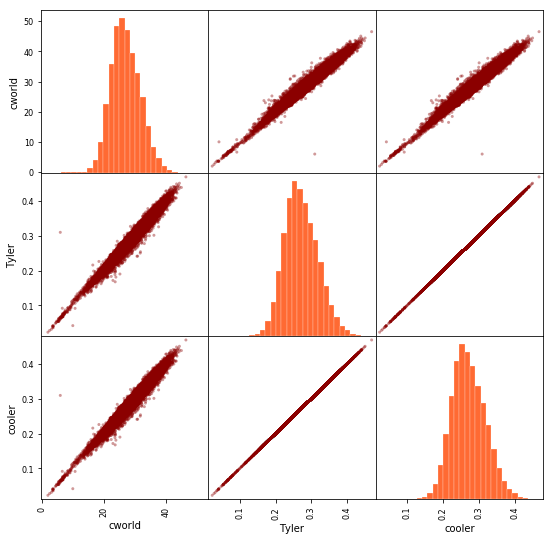

In [63]:
# # range_bins=range_bins
# c.chromnames
# [(chr1,c.offset(chr1)+range_bins,c.offset(chr2)-range_bins) for chr1,chr2 in zip(c.chromnames[:-2],c.chromnames[1:-1])]

# extract only a subset of values from each track - 
# skipping values around chromosome start and ends ...

chrom_pairs = zip(clr.chromnames[:-2],clr.chromnames[1:-1])
offsets = [(clr.offset(chr1)+range_bins, clr.offset(chr2)-range_bins) for chr1,chr2 in chrom_pairs]


# np.isnan(cp_list)

# some final  modifications we need to do
# to the cooler-pipeline generated result
# to make it indistinguishable from Tyler's:
cp_plot = copy(cp_list)
covs_plot = copy(covs-diag/2)
covs_plot[covs==0] = np.nan
covs_plot[tyler_nans > max_NAs] = np.nan


# cvcv = covs-diag/2
ccc = np.concatenate([covs_plot[_1:_2] for _1,_2 in offsets])
ddd = np.concatenate([cp_plot[_1:_2] for _1,_2 in offsets])
kkk = np.concatenate([cworld_bed[_1:_2] for _1,_2 in offsets])


pd.plotting.scatter_matrix(
    pd.DataFrame({"cworld":kkk,"Tyler":ddd,"cooler":ccc}),
    alpha=0.4,
    figsize=(9,9),
    color='darkred',
    hist_kwds={"bins":30,"color":"orangered","alpha":0.8,"edgecolor":'white', "linewidth":0.3})


### Tyler's calculations - via the BED graph file ...

(-100, 72568)

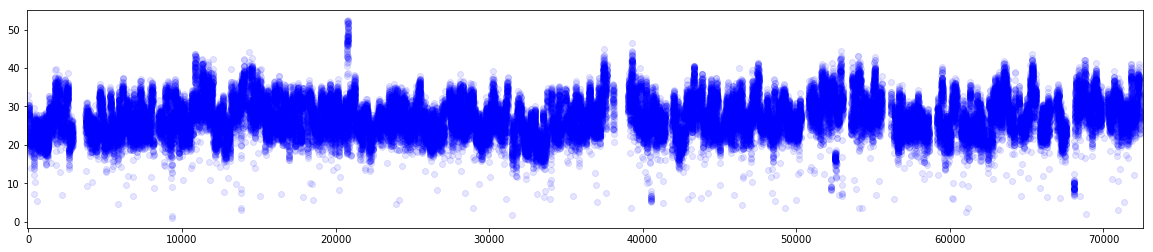

In [64]:
plt.plot(kkk,'bo',alpha=0.1)
fig = plt.gcf()
fig.set_size_inches((20,4))
ax = plt.gca()
ax.set_xlim(-100,kkk.size+100)
# plt.gca().set_ylim((0,0.8))

### proper cooler-streaming pixels style calculations `ccc`

(-100, 72568)

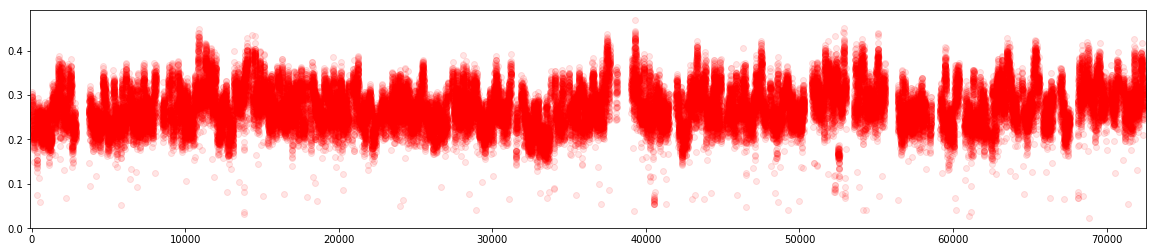

In [65]:
plt.plot(ccc,'ro',alpha=0.1)
fig = plt.gcf()
fig.set_size_inches((20,4))
ax = plt.gca()
ax.set_xlim(-100,ccc.size+100)
# plt.gca().set_ylim((0,0.8))